In [11]:
import os
import sys
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# %matplotlib inline
warnings.filterwarnings('ignore')

# set image building to True/False
* if build_images == False: faster to run, but images won't be generated

In [12]:
build_images = True

# define functions

In [13]:
def visualize_correlations(file_folder, df, file, annotation=True):
    # constroi matriz de correlação de Pearson com valores arredondados (2 decimais)
    corrmatrix = df.corr().apply(lambda x: round(x, 2))

    #constroi heatmap
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corrmatrix, cmap='RdBu', center=0, square=True, annot=annotation, annot_kws={'fontsize':9}, cbar_kws={'shrink':.8 }, 
                yticklabels=1, ax=ax, linewidths=0.1) #
    plt.title('Variable correlations', pad=20, size=15)
    plt.savefig(os.path.join(file_folder, file), bbox_inches = "tight")
    
def calculate_vif(df, threshold=5):
    collinear_vars = []
    variables = list(range(df.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(df.iloc[:, variables].values, ix)
               for ix in range(df.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > threshold:
            var = df.iloc[:, variables].columns[maxloc]
            del variables[maxloc]
            collinear_vars.append(var)
            dropped = True
            
    return collinear_vars

# def save_csv(sufix, label=False):
#     file = sufix + '.csv'
#     if label==False: 
#         df = eval(sufix)
#     else: 
#         df = pd.DataFrame(eval(sufix), columns=[target_var])
#     df.to_csv(os.path.join(outputs, file))

In [14]:
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

# Data capture

In [15]:
inputs = os.path.join('..', 'data', '03_processed')
outputs = os.path.join('..', 'data', '03_processed')
reports = os.path.join('..', 'data', '06_reporting')

data               = pd.read_csv(os.path.join(inputs, 'X_train_onehot.csv'), index_col='id')
data_test          = pd.read_csv(os.path.join(inputs, 'X_test_onehot.csv'), index_col='id')
y_train            = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')

# Visualize correlations

### visualize only continuous data

In [16]:
numerical_cols, _ = get_numerical_mask(data)

# remove dummies as I already checked that they are uncorrelated
dummy_cols = [c for c in numerical_cols if c.startswith('dummy')]
numerical_cols = [c for c in numerical_cols if not c.startswith('dummy')]

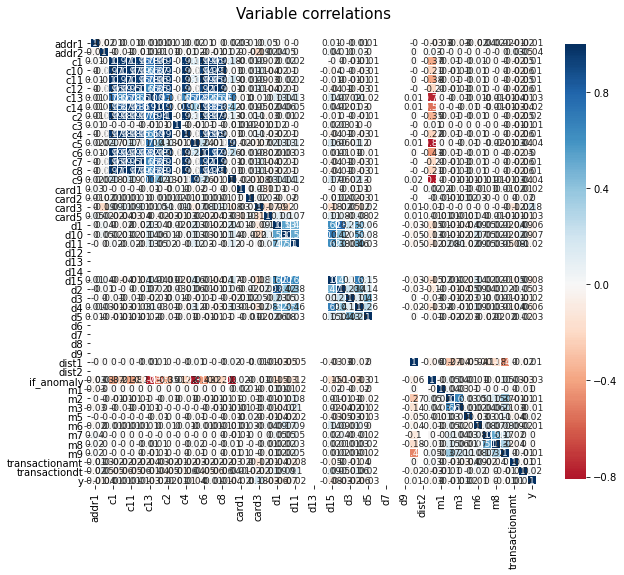

In [17]:
if build_images:
    data_vis = data[numerical_cols]
    data_vis['y'] = y_train['y']
    visualize_correlations(reports, data_vis, '04correlations.jpg')

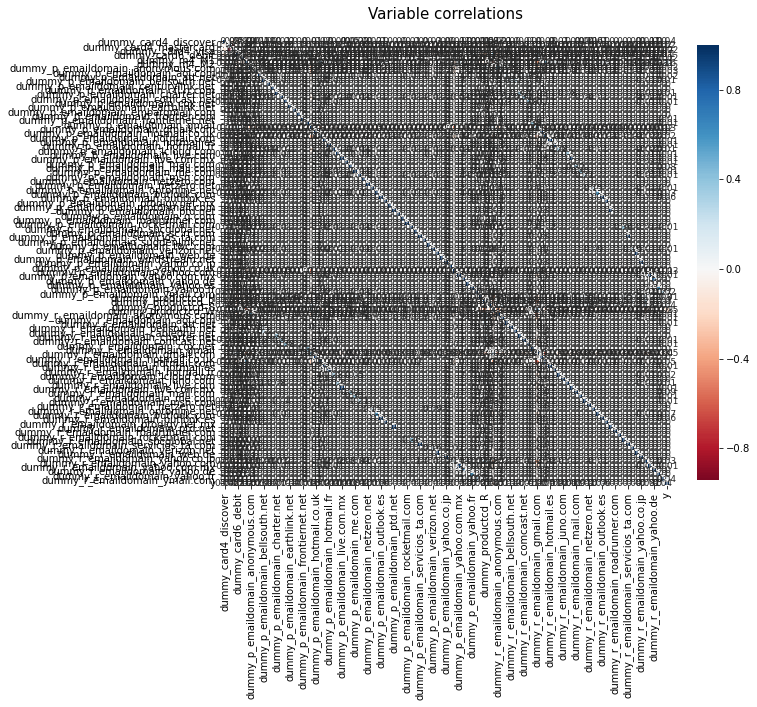

In [18]:
if build_images:
    data_vis = data[dummy_cols]
    data_vis['y'] = y_train['y']
    visualize_correlations(reports, data_vis, '04correlations_dummy.jpg')

# Solve multicollinearity

From the perspective of machine learning models, multicolinearity might bring some problems:
* Coefficients become more sensitive to small changes in the model. 
* Reduction on the precision when estimating coefficients.

One way to measure collinearity is through VIF (variance inflation factor), which measures the rise of variance of the estimation of a parameter given the adition of a new variable. To accomplish this, we can use statsmodel, a Python package. More information at:
* https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html

The rule of thumb is to consider the variable collinear when VIF>5. So we are going to use 5 as the threshold for the removal ot variables. An alternative would be to apply PCA on those variables, but on that case, we would lose explainability.

In [19]:
collinear_vars = calculate_vif(data)
collinear_vars

KeyboardInterrupt: 

# report collinear vars

In [ ]:
import csv
with open(os.path.join(reports, 'collinear_vars.csv'),'w', newline='') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow((['feature']))
    for val in collinear_vars:
        writer.writerow([val])